## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`



## Submit the results

- Submit your results here: https://forms.gle/E7Fa3WuBw3HkPQYg6
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is October 9 (Monday), 23:00 CET. After that the form will be closed.

### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

In [127]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'
!wget $data 

--2023-10-11 13:16:21--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: 'data.csv.4'

data.csv.4          100%[===================>]   1.41M  5.24MB/s    in 0.3s    

2023-10-11 13:16:22 (5.24 MB/s) - 'data.csv.4' saved [1475504/1475504]



In [128]:
select_cols = ['Make', 'Model', 'Year', 'Engine HP' ,'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']
df = pd.read_csv(data, usecols=select_cols)

In [129]:
df

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500
...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,46120
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,56670
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50620
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50920


In [130]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
df = df.fillna(0)
msrp_mean = df['msrp'].mean()
df['above_average'] = np.where(df['msrp'] > msrp_mean,1,0)

In [131]:
df['above_average'].value_counts()

0    8645
1    3269
Name: above_average, dtype: int64

In [132]:
X =  df.drop(['msrp','above_average'],axis=1)
y = df['above_average']

df_full_train, df_val = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_test = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [133]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [134]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [135]:
engine_hp = df_train['engine_hp'].to_numpy()
engine_cylinders = df_train['engine_cylinders'].to_numpy()
highway_mpg = df_train['highway_mpg'].to_numpy()
city_mpg = df_train['city_mpg'].to_numpy()

above_average = df_train['above_average'].to_numpy()

In [136]:
sorted_indices = np.argsort(engine_hp)
engine_hp_sorted = engine_hp[sorted_indices]
above_average_sorted = above_average[sorted_indices]

print("engine_hp Feature Importance Score: ", round(roc_auc_score(above_average_sorted, engine_hp_sorted), 3))

engine_hp Feature Importance Score:  0.917


In [137]:
# Sort the arrays based on engine_hp
sorted_indices = np.argsort(engine_cylinders)
engine_cylinders_sorted = engine_cylinders[sorted_indices]
above_average_sorted = above_average[sorted_indices]

print("engine_cylinders Feature Importance Score: ", round(roc_auc_score(above_average_sorted, engine_cylinders_sorted), 3))

engine_cylinders Feature Importance Score:  0.766


In [138]:
# Sort the arrays based on engine_hp
sorted_indices = np.argsort(highway_mpg)
highway_mpg_sorted = highway_mpg[sorted_indices]
above_average_sorted = above_average[sorted_indices]

print("highway_mpg Feature Importance Score: ", round(roc_auc_score(above_average_sorted, highway_mpg_sorted), 3))

highway_mpg Feature Importance Score:  0.367


In [139]:
# Sort the arrays based on engine_hp
sorted_indices = np.argsort(city_mpg)
city_mpg_sorted = city_mpg[sorted_indices]
above_average_sorted = above_average[sorted_indices]

print("city_mpg Feature Importance Score: ", round(roc_auc_score(above_average_sorted, engine_cylinders_sorted), 3))

city_mpg Feature Importance Score:  0.351


`engine_hp` numerical variable (among the following 4) has the highest AUC?

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [140]:
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = ['make', 'model', 'transmission_type', 'vehicle_style']

In [141]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [142]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [143]:
y_pred = model.predict(X_val)
round(roc_auc_score(y_val, y_pred), 4)

0.9001

0.878 is the closest AUC of this model on the validation dataset?

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [109]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    scores.append((t, p, r))

In [110]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,precision,recall
0,0.00,0.277801,1.000000
1,0.01,0.897893,0.836858
2,0.02,0.897893,0.836858
3,0.03,0.897893,0.836858
4,0.04,0.897893,0.836858
...,...,...,...
96,0.96,0.897893,0.836858
97,0.97,0.897893,0.836858
98,0.98,0.897893,0.836858
99,0.99,0.897893,0.836858


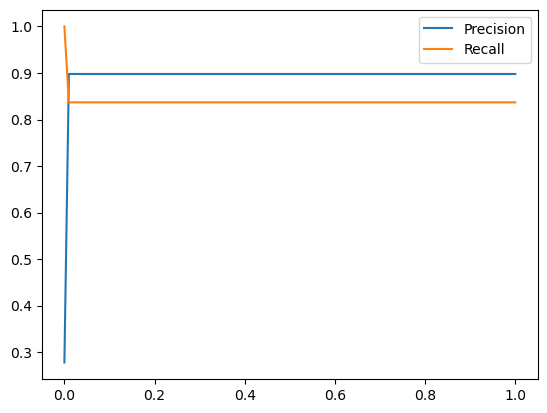

In [111]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

0.88 is at which threshold precision and recall curves intersect

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [114]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * (p*r) / (p+r)
    scores.append((t, p, r, f1))

In [115]:
columns = ['threshold', 'precision', 'recall', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,precision,recall,f1
0,0.00,0.277801,1.000000,0.434811
1,0.01,0.897893,0.836858,0.866302
2,0.02,0.897893,0.836858,0.866302
3,0.03,0.897893,0.836858,0.866302
4,0.04,0.897893,0.836858,0.866302
...,...,...,...,...
96,0.96,0.897893,0.836858,0.866302
97,0.97,0.897893,0.836858,0.866302
98,0.98,0.897893,0.836858,0.866302
99,0.99,0.897893,0.836858,0.866302


In [116]:
df_scores['f1'].max()

0.8663017982799062

0.72 is at which threshold F1 is maximal?

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [117]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [118]:
dv, model = train(df_train, y_train, C=1)

In [119]:
def predict(df_train, dv, model):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [120]:
y_pred = predict(df_val, dv, model)

In [123]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    print('%.3f +- %.3f' % (np.mean(scores) , np.std(scores)))
      

0it [00:00, ?it/s]

0.978 +- 0.000
0.980 +- 0.001
0.979 +- 0.001
0.979 +- 0.001
0.979 +- 0.001


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [124]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.002
C=0.5 0.977 +- 0.001
C=10 0.984 +- 0.003
